# 1. Introduction

This notebook aims to explore the Rohlik orders data from the corresponding [Kaggle challenge](https://www.kaggle.com/competitions/rohlik-orders-forecasting-challenge). The challenge task was to forecast the "orders" column for the test data. In this notebook we will carry out exploratory data analysis to understand these data, with a focus on identifying patterns relevant to the number of orders attributed to the warehouses. We will then apply and compare different forecasting approaches, including more traditional methods (e.g., moving averages, ARIMA), global models (gradient-boosted trees) and neural networks (LSTMs). 

In [2]:
# Basic libraries
import os

# Data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

width, height = 9, 6

# Encoding and crossvalidation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# Traditional methods

# Models to be used as global models

# Deep learning

# # Remove warnings for notebook
# import warnings
# warnings.filterwarnings("ignore")

# 2. Basic data processing

In this section, we will have an initial look at the data and do some basic data processing, including:
 * Identifying missing data
 * Making datetime features
 * Joining tables

This section will not deal with generating more advanced time series features (e.g., lags) or feature processing like one-hot encoding or scaling.

There are five files provided for this project (descriptions from kaggle):
 * **train.csv** - the training set containing the historical orders data and selected features described below
 * **test.csv** - the test set
 * **solution_example.csv** - a sample submission file in the correct format
 * **train_calendar.csv** - a calendar for the training set containing data about holidays or warehouse specific events, some columns are already in the train data but there are additional rows in this file for dates where some warehouses could be closed due to public holiday or Sunday (and therefore they are not in the train set)
 * **test_calendar.csv** - a calendar for the test set

In [3]:
# data_dir = os.path.join("/kaggle", "input", "rohlik-orders-forecasting-challenge")
data_dir = os.path.join("rohlik-orders-forecasting-challenge")

# Load the CSV files into a dictionary
original_data = {}

for file_name in os.listdir(data_dir):
    original_data[file_name.replace(".csv", "")] = pd.read_csv(
        os.path.join(data_dir, file_name)
    )

    # Convert dates to datetime format
    if "date" in original_data[file_name.replace(".csv", "")].columns:
        original_data[file_name.replace(".csv", "")]["date"] = pd.to_datetime(
            original_data[file_name.replace(".csv", "")]["date"]
        )
        original_data[file_name.replace(".csv", "")] = original_data[
            file_name.replace(".csv", "")
        ].set_index("date")

Let's have a look at our data. The training set has information on holidays, warehosue shutdowns/blackouts, mov_change (change in minimum order value), weather and user activity on the website. We also get a `train_calendar` dataframe - much of the information from this is already in the training data, but there are additional rows in this file for dates when the warehouses are closed (i.e., due to public holidays or Sunday).

In [4]:
train, test = original_data["train"], original_data["test"]
train.head(5)

,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
date,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
2020-12-06,Prague_1,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2020-12-07,Prague_1,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
2020-12-08,Prague_1,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
2020-12-09,Prague_1,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


We'll do most of our visualisation in the next section, but it's worth getting some context by looking at a plot of our time series. There are clear seasonal patterns shared across the warehouses. It's also worth noting that some of the warehouses span the entire date range, whereas others opened more recently. 

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_34356\1341787534.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


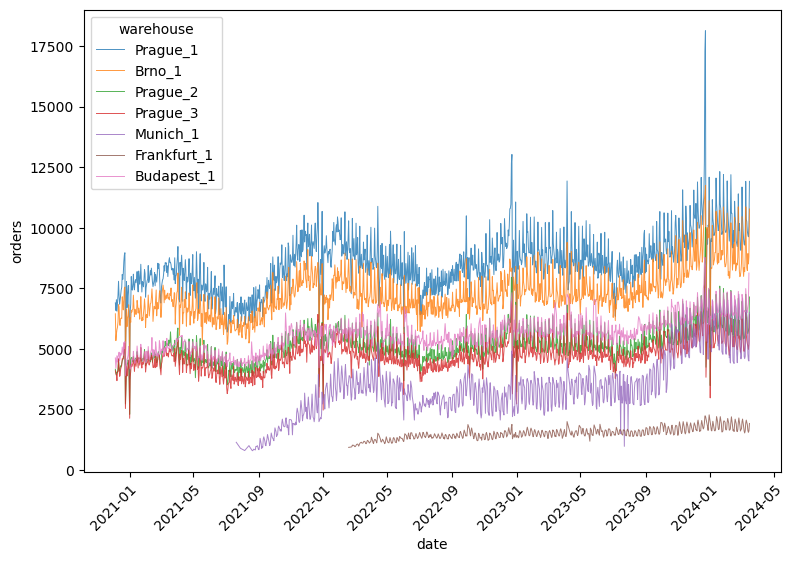

In [5]:
plt.figure(figsize=(width, height))
sns.lineplot(
    data=original_data["train"],
    x=original_data["train"].index,
    y=original_data["train"]["orders"],
    hue=original_data["train"]["warehouse"],
    linewidth=0.7,
    alpha=0.8,
)
ax = plt.gca()
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor"
)
plt.show()

## 2.1 Missing data

Below we see the ranges of the time series. All of them stop on `2024-03-15`, except for Budapest_1, because this was a holiday. Additionally, we see the differing start dates for the warehosues.

In [6]:
dates_df_train = (
    train.reset_index().groupby(["warehouse"])["date"].agg(["min", "max"]).reset_index()
)
dates_df_train.columns = ["warehouse", "start_date", "end_date"]
dates_df_train

,warehouse,start_date,end_date
0,Brno_1,2020-12-05,2024-03-15
1,Budapest_1,2020-12-05,2024-03-14
2,Frankfurt_1,2022-02-18,2024-03-15
3,Munich_1,2021-07-21,2024-03-15
4,Prague_1,2020-12-05,2024-03-15
5,Prague_2,2020-12-05,2024-03-15
6,Prague_3,2020-12-05,2024-03-15


The test set ranges from `2024-03-16` to `2024-05-15` for all warehouses.

In [7]:
dates_df_test = (
    test.reset_index().groupby(["warehouse"])["date"].agg(["min", "max"]).reset_index()
)
dates_df_test.columns = ["warehouse", "start_date", "end_date"]
dates_df_test

,warehouse,start_date,end_date
0,Brno_1,2024-03-16,2024-05-15
1,Budapest_1,2024-03-16,2024-05-15
2,Frankfurt_1,2024-03-16,2024-05-15
3,Munich_1,2024-03-16,2024-05-15
4,Prague_1,2024-03-16,2024-05-15
5,Prague_2,2024-03-16,2024-05-15
6,Prague_3,2024-03-16,2024-05-15


There are missing days in the train/test sets for some of the series, mostly due to lack of recording for Sundays. All of these instances are in the training and test calendars. For completeness, we will add rows for these dates, and simply leave the outcome and other missing variables as NA.

In [8]:
def add_missing_days(d, calendar, date_range, train_split=True):
    """Add the missing days in `d` while retaining holiday information."""

    d = d.copy()
    calendar = calendar.copy()


    # Add missing columns
    calendar["id"] = (
        calendar["warehouse"]
        + "_"
        + calendar.index.year.astype(str)
        + "-"
        + calendar.index.month.astype(str)
        + "-"
        + calendar.index.year.astype(str)
    )


    calendar["user_activity_1"], calendar["user_activity_2"] = np.nan, np.nan

    if train_split:
        calendar["orders"] = np.nan


    # Indicate that the dates we are adding are closed days

    calendar["closed"] = 1

    d["closed"] = 0


    # Remove dates prior to opening
    calendar = calendar[
        (calendar.index >= date_range[0]) & (calendar.index <= date_range[1])
    ]


    if train_split:

        dates_df_train = (
            d.reset_index()
            .groupby(["warehouse"])["date"]
            .agg(["min", "max"])
            .reset_index()
        )
        dates_df_train.columns = ["warehouse", "start_date", "end_date"]


        for warehouse_name in dates_df_train["warehouse"]:
            calendar = calendar[
                ~(
                    (
                        calendar.index
                        < dates_df_train["start_date"][
                            dates_df_train["warehouse"] == warehouse_name
                        ].values[0]
                    )
                    & (calendar["warehouse"] == warehouse_name)
                )
            ]


    # Get date + warehouse index

    d = d.reset_index().set_index(["date", "warehouse"])

    calendar = calendar.reset_index().set_index(["date", "warehouse"])


    # Get the dates that aren't in the train/test sets

    calendar = calendar[~calendar.index.isin(d.index)]


    # Add these rows to the train/test sets

    d = pd.concat([d, calendar]).reset_index().set_index("date")

    return d


train = add_missing_days(
    train,
    original_data["train_calendar"].drop("warehouse_limited", axis=1),
    date_range=("2020-12-05", "2024-03-15"),
    train_split=True,
)

test = add_missing_days(
    test,
    original_data["test_calendar"],
    date_range=("2024-03-16", "2024-05-15"),
    train_split=False,
)

In [9]:
# For each warehouse/data split
for warehouse_name in train["warehouse"].unique():
    for d in [train, test]:

        # Check for missing dates within the range
        d_warehouse = d[d["warehouse"] == warehouse_name]
        full_range = pd.date_range(
            start=d_warehouse.index.min(), end=d_warehouse.index.max(), freq="D"
        )
        missing_dates = full_range.difference(d_warehouse.index)

        if len(missing_dates) > 0:
            print("Missing dates:", missing_dates)

        # Check for duplicates
        assert not d_warehouse.index.duplicated().any()

It's worth noting that there are some features available in the training but not the test data. These are listed below.

We can group these into four categories:
 1. Shutdowns
 2. Change in minimum order value (mov_change)
 3. Weather
 4. User activity

In section 3 of this notebook we will consider whether these variables may have value for the prediction of sales. If so, it may be worth attempting to forecast these for the test data before attempting to predict order status. 

Now, let's look at the number of NAs for each column. There are missing variables for the following columns:
 - `orders`, `user_activity`: We introduced these NAs when we filled in the missing dates. In reality, these days had 0 sales because they were closed. We will deal with these at the modelling stage - either by specifying that there were 0 orders or allowing the methods to deal with the NAs themselves.
 - `holiday_name`: These missings don't match up with the holiday variable, though, as there are instances where `holiday == 1` but there is no holiday name, and cases where `holiday == 0` but there is a holiday name (i.e., minor "holidays" that aren't associated with time off). We'll fill in the missing holiday names with "none_or_unknown".
 - `precipitation`, `snow`: There are two issues here. First, there are a small number of seemingly random missing dates. Secondly, the weather data for Prague_3 is missing for a period. To deal with the small number of missing dates, we'll use interpolation. To deal with the longer missing prague period, we will fill the Prague_3 data using the Prague_2 data, which is highly correlated (as shown by the plots below).

 Number of NAs by column:


In [10]:
# Get NAs
na_counts = train.isna().sum()
print(na_counts)

# Fill in holiday NAs
train.loc[train["holiday_name"].isna(), "holiday_name"] = "none_or_unknown"
test.loc[test["holiday_name"].isna(), "holiday_name"] = "none_or_unknown"

warehouse                    0
orders                     371
holiday_name              7377
holiday                      0
shutdown                     0
mini_shutdown                0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
blackout                     0
mov_change                   0
frankfurt_shutdown           0
precipitation              274
snow                       274
user_activity_1            371
user_activity_2            371
id                           0
closed                       0
dtype: int64


The plots below show the correlation of the Prague_3 warehouse vs. the other nearby warehouses. It seems the weather data is identical for Prague 1 and 2 but slightly different for Prague_3. The data are very similar though, so it seems reasonable to use the nearby precipitation data to fill the early Prague_3 values.

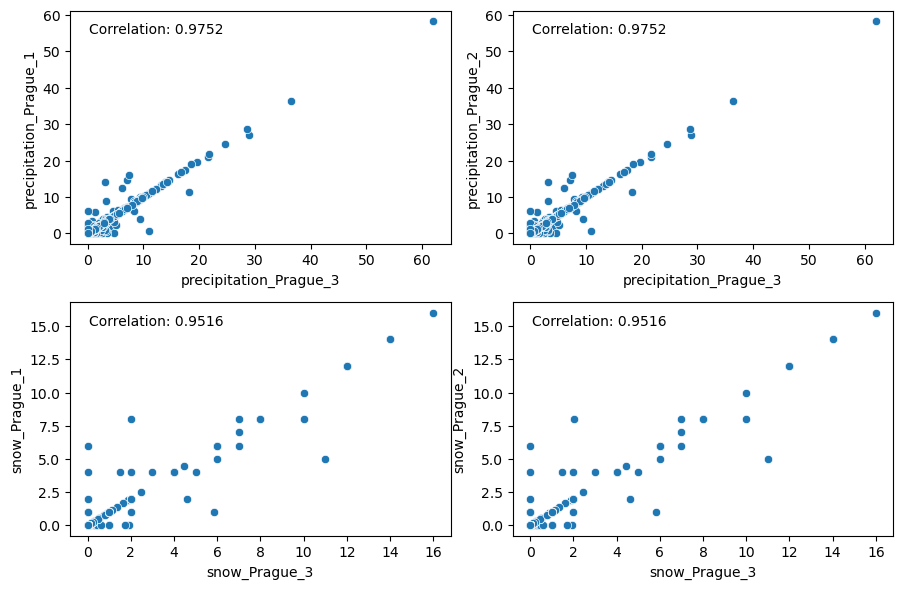

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(width, height))

# For each weather variable
for i, var_to_plot in enumerate(["precipitation", "snow"]):

    # Plot the comparisons of prague 3 to each of the other prague locations
    for j, plot_pairs in enumerate(
        [["Prague_3", "Prague_1"], ["Prague_3", "Prague_2"]]
    ):

        # Make plot for pair of warehouses
        weather_paired = (
            train.loc[train["warehouse"] == plot_pairs[0], var_to_plot]
            .reset_index()
            .join(
                train.loc[train["warehouse"] == plot_pairs[1], var_to_plot]
                .reset_index()
                .set_index("date"),
                lsuffix=f"_{plot_pairs[0]}",
                rsuffix=f"_{plot_pairs[1]}",
                how="left",
                on="date",
            )
        )

        sns.scatterplot(
            data=weather_paired,
            x=f"{var_to_plot}_{plot_pairs[0]}",
            y=f"{var_to_plot}_{plot_pairs[1]}",
            ax=ax[i, j],
        )

        # Report correlation
        correlation = weather_paired[f"{var_to_plot}_{plot_pairs[0]}"].corr(
            weather_paired[f"{var_to_plot}_{plot_pairs[1]}"]
        )
        ax[i, j].annotate(
            f"Correlation: {correlation:.4f}",
            xy=(0.05, 0.9),  # Coordinates in figure fraction (0 to 1)
            xycoords="axes fraction",  # Coordinate system of the plot
            fontsize=10,
        )

    # Fill missing prague 3 values with alternative prague values
    # Check the dates and NAs line up between the weather_paired and train dataframes
    weather_paired = weather_paired.set_index("date")
    assert (weather_paired.index == train.index[train["warehouse"] == "Prague_3"]).all()
    assert (
        train.loc[train["warehouse"] == "Prague_3", var_to_plot].isna()
        == weather_paired[f"{var_to_plot}_Prague_3"].isna()
    ).all()

    # Set the missing prague 3 values to the prague 2 values, then merge with the train set
    weather_paired.loc[
        weather_paired[f"{var_to_plot}_Prague_3"].isna(), f"{var_to_plot}_Prague_3"
    ] = weather_paired.loc[
        weather_paired[f"{var_to_plot}_Prague_3"].isna(), f"{var_to_plot}_Prague_2"
    ]
    train.loc[train["warehouse"] == "Prague_3", var_to_plot] = weather_paired[
        f"{var_to_plot}_Prague_3"
    ]

plt.tight_layout()
plt.show()

In [12]:
# Interpolate remaining precipitation values
for warehouse_name in train["warehouse"].unique():
    for var_to_interpolate in ["precipitation", "snow"]:
        train.loc[train["warehouse"] == warehouse_name, var_to_interpolate] = train.loc[
            train["warehouse"] == warehouse_name, var_to_interpolate
        ].interpolate(method="time", limit_direction="forward")

Finally, the only missing variables are for the `orders` and `user_activity` columns, and we know their true values for these days are in fact 0.

In [13]:
train.isna().sum()

warehouse                   0
orders                    371
holiday_name                0
holiday                     0
shutdown                    0
mini_shutdown               0
shops_closed                0
winter_school_holidays      0
school_holidays             0
blackout                    0
mov_change                  0
frankfurt_shutdown          0
precipitation               0
snow                        0
user_activity_1           371
user_activity_2           371
id                          0
closed                      0
dtype: int64

## 2.2 Create features

### 2.2.1 Date and holiday-related features

We add features for the year (years from study start), month, day of year, day of month and day of week.

In [14]:
# Years from dataset start rather than the actual year
train["year"] = train.index.year - train.index.year.min()

# Month and day of
train["month"] = train.index.month
train["dayofyear"] = train.index.dayofyear
train["dayofmonth"] = train.index.day
train["dayofweek"] = train.index.dayofweek

There is an uptick of orders around the holidays. We add information about upcoming holidays to the calendars. These are known in advance, so we are not worried about data leakage.

In [18]:
len(1)

TypeError: object of type 'int' has no len()

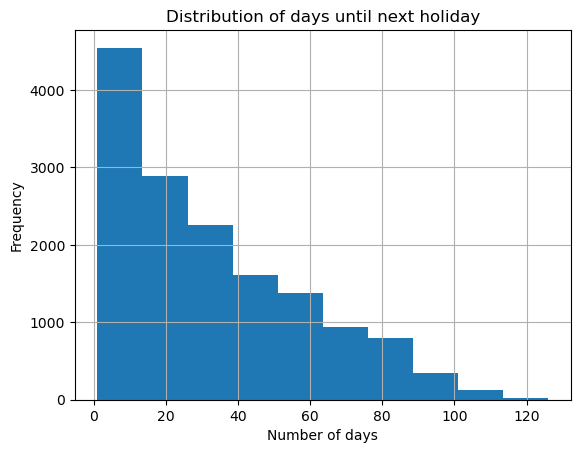

In [49]:
def get_next_holiday(calendar):
    """
    Takes a calendar and returns a new dataframe with the following columns:
    - `days_until_next_holiday`
    - `next_holiday_name`
    """

    # Set up the sorted calendar with new columns
    calendar = calendar.copy()
    calendar = calendar.sort_index()
    calendar.loc[calendar["holiday_name"].isna(), "holiday_name"] = "none_or_unknown"
    calendar["days_until_next_holiday"], calendar["days_since_last_holiday"] = (
        np.nan,
        np.nan,
    )
    calendar["next_holiday_name"], calendar["last_holiday_name"] = None, None

    # Small function for getting the holiday name for a given date/warehouse
    def get_holiday_name(date, warehouse):
        holiday_name = calendar[
            (calendar.index == date) & (calendar["warehouse"] == warehouse)
        ]["holiday_name"]

        try:
            assert len(holiday_name) == 1
        except Exception as e:
            print(date)
            print("--")
            print(warehouse)
            print("--")
            print(holiday_name)

        holiday_name = holiday_name.iloc[0]

        return holiday_name

    # For each day
    for i in range(len(calendar)):

        # Find the last and next holiday dates
        warehouse_name = calendar["warehouse"].iloc[i]
        warehouse_holidays = calendar.index[
            (calendar["holiday"] == 1) & (calendar["warehouse"] == warehouse_name)
        ]
        future_holidays = warehouse_holidays[warehouse_holidays > calendar.index[i]]
        past_holidays = warehouse_holidays[warehouse_holidays < calendar.index[i]]

        # Fill in future holidays up to this date
        if calendar.index[i] < pd.Timestamp("2024-10-31"):
            calendar.iloc[i, calendar.columns.get_loc("days_until_next_holiday")] = (
                future_holidays.min() - calendar.index[i]
            ).days
            calendar.iloc[i, calendar.columns.get_loc("next_holiday_name")] = (
                get_holiday_name(future_holidays.min(), warehouse_name)
            )

        # Fill in past holidays, except for first day of timeline (which we fill in manually)
        if calendar.index[i] == pd.Timestamp("2019-01-01"):
            calendar.iloc[i, calendar.columns.get_loc("days_since_last_holiday")] = 6
            calendar.iloc[i, calendar.columns.get_loc("last_holiday_name")] = (
                "2nd Christmas Day"
            )
        else:
            calendar.iloc[i, calendar.columns.get_loc("days_since_last_holiday")] = (
                calendar.index[i] - past_holidays.max()
            ).days
            calendar.iloc[i, calendar.columns.get_loc("last_holiday_name")] = (
                get_holiday_name(past_holidays.max(), warehouse_name)
            )

    return calendar[
        [
            "warehouse",
            "days_until_next_holiday",
            "next_holiday_name",
            "days_since_last_holiday",
            "last_holiday_name",
        ]
    ]


# Get next holiday data and join to the main datasets
next_holiday = get_next_holiday(
    pd.concat([original_data["train_calendar"], original_data["test_calendar"]])
)

next_holiday["days_until_next_holiday"].hist()
plt.title("Distribution of days until next holiday")
plt.xlabel("Number of days")
plt.ylabel("Frequency")
plt.show()

# train = pd.merge(
#     train.reset_index(),
#     next_holiday.reset_index(),
#     on=["date", "warehouse"],
#     how="left",
# ).set_index("date")

# test = pd.merge(
#     test.reset_index(), next_holiday.reset_index(), on=["date", "warehouse"], how="left"
# ).set_index("date")

In [50]:
next_holiday

,warehouse,days_until_next_holiday,next_holiday_name,days_since_last_holiday,last_holiday_name
date,,,,,
2019-01-01,Budapest_1,73.0,Memorial Day for the Victims of the Holocaust,6.0,2nd Christmas Day
2019-01-01,Prague_2,108.0,Good Friday,6.0,2nd Christmas Day
2019-01-01,Prague_1,108.0,Good Friday,6.0,2nd Christmas Day
2019-01-01,Prague_3,108.0,Good Friday,6.0,2nd Christmas Day
2019-01-01,Frankfurt_1,108.0,Good Friday,6.0,2nd Christmas Day
...,...,...,...,...,...
2024-12-07,Budapest_1,NaN,None,36.0,All Saints Day
2024-12-07,Prague_1,NaN,None,20.0,Den boje za svobodu a demokracii
2024-12-07,Brno_1,NaN,None,20.0,Den boje za svobodu a demokracii


### 2.2.X Miscellaneous features

 * Region variable
 * Categorical weather and move change variables

In [ ]:
train["region"], test["region"] = (
    train["warehouse"].str.split("_").str[0],
    test["warehouse"].str.split("_").str[0],
)

# 3. Data exploration

Initial order visualisation for the training set

# 4. Traditional modelling

# 5. Global modelling

# 6. Deep learning

# 7. Approach comparison

# 8. Conclusions

## 8.1 Limitations and next steps

 * Precipitation, snow and user activity are available for the training but not the test data. For our global model, we forecasted these as an initial step, then fed these predictions into the orders forecaster. In this project we were limited to the data we had available, but in reality it would be better to use the "real" weather forecast, as the models this is based on are more complex and incorporate more information.
 * Other solutions found an increase in predictive performance when filling in holidays using external information (e.g., https://www.kaggle.com/code/darkswordmg/rohlik-2024-2nd-place-solution-single-lgbm#3.-Data-processing). 
 * The feature engineering carried out in this project were primarily designed for use by the non-linear methods (i.e., boosted trees). We might have been able to improve the ARIMA models further, for example by providing simpler exogenous variables.

TODO:

* Consider remaining feature engineering based on rohlik notebook + 2nd place solution
* Make visualisations, including things from above notebooks, analysis of individual variables, correlations with outcome
* Apply traditional modelling
* Use XGBoost/LGBM with appropriate transformers (tfidfvectorizer, LabelEncoder, pipeline, ColumnTransformer, TransformedTargetRegressor)
* Apply an LSTM approach